In [1]:
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt, medfilt
import plotly
pd.options.plotting.backend = "plotly"

In [6]:
def smoothing_filt(data, kernel_size):
    kernel = np.ones(kernel_size) / kernel_size
    data_convolved = np.convolve(data, kernel, mode='same')
    return pd.DataFrame(data_convolved)

def detrend_sig(baseline, sig):
    p = np.polyfit(range(1,len(baseline)+1),baseline,1)
    z = np.polyval(p,range(1,len(sig)+1))
    
    return (sig-pd.DataFrame(z))

def filt(raw_signal, fs):
# raw_signal = PPG_D1
# Lowpass filtering
    A_low = 100
    delt_w_low = 7.21 - 3.8
    M_low = (A_low-8)/(2.285*delt_w_low)
    order_low = 80
    fc_low = 6

    b_low = signal.firwin(order_low, fc_low, window=('kaiser', M_low), fs=fs) 
    filtered_low = filtfilt(b_low, 1, raw_signal)

# Highpass filtering
    fc_high = 0.5
    order_high = 201

    b_high = signal.firwin(order_high, fc_high, window='hamming', pass_zero=False, fs=fs)       # WHY????
    filtered_high = filtfilt(b_high, 1, filtered_low)

    filtered_signals = [raw_signal, filtered_low, filtered_high]
    
    return filtered_signals

def filt_with_params(raw_signal, fs, order_low, fc_low, order_high, fc_high):
# raw_signal = PPG_D1
# Lowpass filtering
    A_low = 100
    delt_w_low = 7.21 - 3.8
    M_low = (A_low-8)/(2.285*delt_w_low)
#     order_low = 80
#     fc_low = 6

    b_low = signal.firwin(order_low, fc_low, window=('kaiser', M_low), fs=fs) 
    filtered_low = filtfilt(b_low, 1, raw_signal)

# Highpass filtering
#     fc_high = 0.5
#     order_high = 201

    b_high = signal.firwin(order_high, fc_high, window='hamming', pass_zero=False, fs=fs)       # WHY????
    filtered_high = filtfilt(b_high, 1, filtered_low)

    filtered_signals = [raw_signal, filtered_low, filtered_high]
    
    return filtered_signals

HEIGHT = 165
def get_pulses(data):
    neg_peaks, _ = signal.find_peaks(-data, distance=60)
    avg_pulse_len = np.mean(np.diff(neg_peaks)) 

    pulses = []
    for i in range(len(neg_peaks)-1):
        pulse = np.zeros(int(avg_pulse_len*1.2))
        p_len = neg_peaks[i+1]-neg_peaks[i]
        
        if (p_len<avg_pulse_len*1.2)&(p_len>avg_pulse_len*0.8):
            p = data[neg_peaks[i]:neg_peaks[i+1]]
            pulse[:p_len] = p - min(p)
            pulses.append(pulse)
            # plt.plot(pulse)
    # plt.show()
    return pulses

def get_norm_pulses(data, normalize):
    neg_peaks, _ = signal.find_peaks(-data, distance=60)
    avg_pulse_len = np.mean(np.diff(neg_peaks)) 

    pulses = []
    for i in range(len(neg_peaks)-1):
        pulse = np.zeros(int(avg_pulse_len*1.2))
        p_len = neg_peaks[i+1]-neg_peaks[i]
        
        if (p_len<avg_pulse_len*1.2)&(p_len>avg_pulse_len*0.8):
            p = data[neg_peaks[i]:neg_peaks[i+1]]
            pulse[:p_len] = p - min(p)
            if normalize:
                pulse_max = max(pulse)
            else:
                pulse_max = 1
            pulses.append(pulse/pulse_max)
            # plt.plot(pulse)
    # plt.show()
    return pulses

def get_pk_locs(pulse):
    sys_pk_loc = np.argmax(pulse)  
    sys_wave = np.zeros(len(pulse))
    sys_wave_half = pulse[:sys_pk_loc]
    sys_wave[:sys_pk_loc*2] = np.concatenate([sys_wave_half,np.flip(sys_wave_half)])
    di_wave = pulse - sys_wave

    rel_pul = pulse[sys_pk_loc:]
    derivative = np.gradient(rel_pul)
    peaks, _ = signal.find_peaks(derivative)
    di_pk_loc = peaks[0]+sys_pk_loc 
    
    neg_peaks,_ = signal.find_peaks(-derivative)
    split_pnt = neg_peaks[0] + sys_pk_loc
    
    print(peaks)
    plt.axhline(y=0)
    plt.plot(pulse)
    plt.plot(derivative)
    plt.plot(sys_wave)
    plt.plot(di_wave)
    plt.plot(split_pnt, pulse[split_pnt], "x")
    plt.title('Systolic Wave and Diastolic Wave')
    plt.legend(['Pulse','Derivative', 'Systolic Wave','Diastolic Wave'])
    plt.xlabel('Sample Points')
    plt.ylabel('Amplitude')
    plt.show()
#     IPA = np.trapz(di_wave)/np.trapz(sys_wave)
    IPA = np.trapz(pulse[split_pnt:]) / np.trapz(pulse[:split_pnt])

    return [di_pk_loc, sys_pk_loc, IPA, derivative[peaks[0]] ]

def pulse_indices(pulse):
    # Indices: sys_pk, AUC, delt_T, CT, RI, SI, STT, IPA, pulse_wa_ratio
    [di_pk_loc, CT, IPA, der_pk] = get_pk_locs(pulse)
    sys_pk = max(pulse)
    di_pk = pulse[di_pk_loc]

    RI = di_pk/sys_pk
    delt_T = di_pk_loc - CT
    SI = HEIGHT/delt_T
    STT = CT/sys_pk
    pulse_wa_ratio = len(pulse)/sys_pk
    AUC = np.trapz(pulse)
    peak_diff_t = di_pk_loc - CT

    return [sys_pk, AUC, delt_T, CT, RI, SI, STT, IPA, pulse_wa_ratio, der_pk, peak_diff_t, di_pk ]

In [22]:
dataset = {
    "age24H1":("age24Jan52022.csv",14400,17000, "Healthy" , 4943, True),
    "age24H2":("age24Jan102022.csv",14400,17000, "Healthy", 4783, True),
#     "age53H3":("age53Dec292021.csv",14400,17000, "Healthy", 7560, True),
    "age21H4":("age21Jan52022.csv",21000,23600, "Healthy" , 5116, True),
    "age21H5":("age21Jan102022.csv",14400,17000, "Healthy", 4956, True),
#     "age26H6":("age26Feb62022.csv",14400,17000, "Healthy", 5288, False),
    "age26H7":("age26_2Feb62022.csv",14400,17000, "Healthy", 4979, True),
#     "age26H8":("age26_3Feb62022.csv",14400,17000, "Healthy", 5721, False ),
    "age60D1":("ageChandraniAmarasinghe.csv",1000,3600, "Diabetic", 5250, True),
    "age61D2":("ageUManaliAmarasinghe.csv",14400,17000, "Diabetic", 5624, True),
#     "age24D3":("age24Feb82022.csv",14400,17000, "Diabetic" , 5050, True),
    "age52D4":("twFeb-15-2022.csv",14400,17000, "Diabetic" , 5050, True)
}


(77134, 1)


/home/pulasthi/anaconda3/envs/aienv/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/pulasthi/anaconda3/envs/aienv/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in sqrt
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


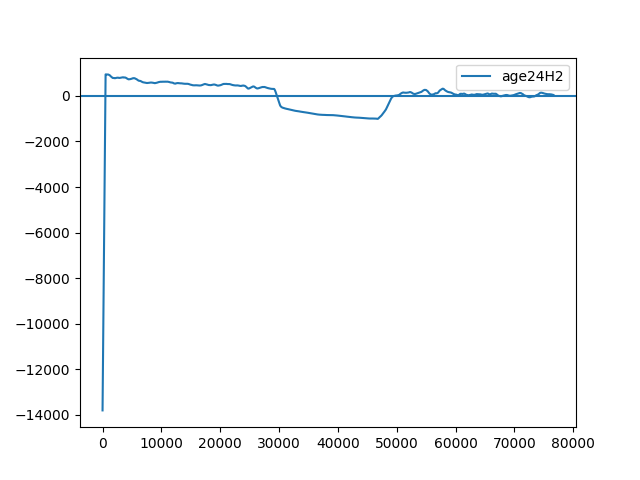

In [66]:
def smoothing_filt(data, kernel_size):
    kernel = np.ones(kernel_size) / kernel_size
    data_convolved = np.convolve(data, kernel, mode='same')
    return pd.DataFrame(data_convolved)

def filt(raw_signal, fs):
# raw_signal = PPG_D1
# Lowpass filtering
    A_low = 100
    delt_w_low = 7.21 - 3.8
    M_low = (A_low-8)/(2.285*delt_w_low)
    order_low = 80
    fc_low = 6

    b_low = signal.firwin(order_low, fc_low, window=('kaiser', M_low), fs=fs) 
    filtered_low = filtfilt(b_low, 1, raw_signal)
    
    return filtered_low
ppg ={}
filtered_ppg ={}
ppg_seg = {}
avg_pulse_ppg = {}
ppg_indices = {}
fs = 100
plt.clf()
plt.cla()
plt.close()
for patient,data in dataset.items():
    dataframe = pd.read_csv("Data/"+data[0])
    sdata = dataframe["PData"]
    scdata = dataframe["SCData"]
    smoothed_sdata = smoothing_filt(sdata, 1000)
    mean_rmv_sdata = smoothed_sdata - np.average(smoothed_sdata.dropna())
    
    smoothed_scdata = smoothing_filt(scdata, 1000)
    mean_rmv_scdata = smoothed_scdata - np.average(smoothed_scdata.dropna())
    
    print(mean_rmv_scdata.shape)
    result = scipy.stats.linregress(np.transpose(mean_rmv_scdata[8000:30000]), np.transpose(mean_rmv_sdata[8000:30000]))
    estimate = (result.slope)*mean_rmv_scdata + result.intercept
#     filtered_ppg[patient] = filt(ppg[patient],fs)
#     plt.plot(estimate)
#     plt.plot(mean_rmv_scdata)
    plt.plot(mean_rmv_sdata)
#     plt.plot(mean_rmv_sdata - estimate)
    plt.axhline(y=0)
#     plt.legend(["Estimate", "SCData", "SData", "Diff"])
#     ppg_seg[patient] = filtered_ppg[patient][2][data[1]:data[2]]
#     avg_pulse_ppg[patient] = np.mean(get_pulses(ppg_seg[patient]), axis=0)
#     ppg_indices[patient] = pulse_indices(avg_pulse_ppg[patient])
#     print(f"ppg_indices['{patient}'] ={ppg_indices[patient]}")
#     plt.plot(avg_pulse_ppg[patient])
    
plt.legend(dataset.keys())
plt.show()

[12 39]


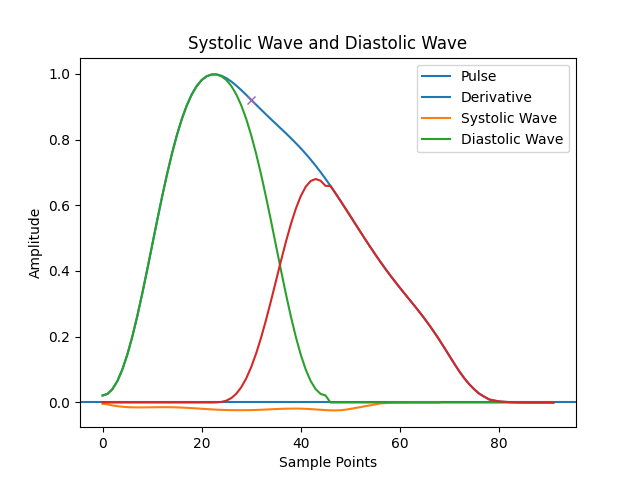

ppg_indices['age52D4'] =[0.998096668968083, 42.21759638295619, 12, 23, 0.8490975156129017, 13.75, 23.043860094012086, 1.234817503375829, 92.17544037604834, -0.014240300025706087, 12, 0.847481401962312]


In [115]:
patient =  "age52D4"
data = dataset[patient]
plt.figure(2)
plt.clf()
dataframe = pd.read_csv("Data/"+data[0])
ppg[patient] = dataframe["SCData"]
filtered_ppg[patient] = filt(ppg[patient],fs)
ppg_seg[patient] = filtered_ppg[patient][2][data[1]:data[2]]
avg_pulse_ppg[patient] = np.mean(get_norm_pulses(ppg_seg[patient], True), axis=0)
ppg_indices[patient] = pulse_indices(avg_pulse_ppg[patient])
print(f"ppg_indices['{patient}'] ={ppg_indices[patient]}")
plt.plot(avg_pulse_ppg[patient])

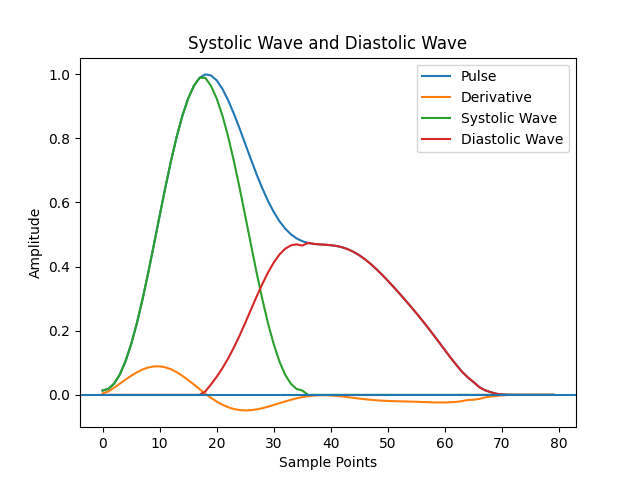

ppg_indices['age24H1'] =[0.9992003489762625, 30.741095144774516, 18, 18, 0.47410825982504196, 9.166666666666666, 18.01440523759026, 0.8647432229990004, 80.06402327817894]


In [48]:
patient =  "age24H1"
data = dataset[patient]
plt.figure(1)
plt.clf()
dataframe = pd.read_csv("Data/"+data[0])
ppg[patient] = dataframe["SCData"]
filtered_ppg[patient] = filt(ppg[patient],fs)
ppg_seg[patient] = filtered_ppg[patient][2][data[1]:data[2]]
avg_pulse_ppg[patient] = np.mean(get_norm_pulses(ppg_seg[patient], True), axis=0)
ppg_indices[patient] = pulse_indices(avg_pulse_ppg[patient])
print(f"ppg_indices['{patient}'] ={ppg_indices[patient]}")
plt.plot(avg_pulse_ppg[patient])

ppg_indices['age24H1'] =[0.9990712281746209, 31.239925583056994, 21, 20, 0.4769694677749501, 7.857142857142857, 20.01859270488804, 0.8728918119878596, 80.07437081955216, -0.009807412936102738, 21, 0.47652647197171466]
ppg_indices['age24H2'] =[0.9987547156357264, 33.27612780350408, 20, 21, 0.5167852613025001, 8.25, 21.026183577649594, 1.0185741965635788, 85.10598114762931, -0.009590737507650937, 20, 0.5161417166969131]
ppg_indices['age53H3'] =[0.9965246913289207, 36.77316333636247, 17, 24, 0.6676601541576346, 9.705882352941176, 24.083698285483198, 0.7701627338908728, 84.29294399919118, -0.021091535765103864, 17, 0.6653398290345565]
ppg_indices['age21H4'] =[0.998141453255614, 39.508744962173495, 18, 22, 0.6717901317748338, 9.166666666666666, 22.04096416218676, 1.2508196302932748, 93.17316668560767, -0.012313632247817952, 18, 0.670541578412513]
ppg_indices['age21H5'] =[0.9949699909270693, 37.01263751335772, 18, 21, 0.6812889469749704, 9.166666666666666, 21.106164197407725, 1.0635572934639

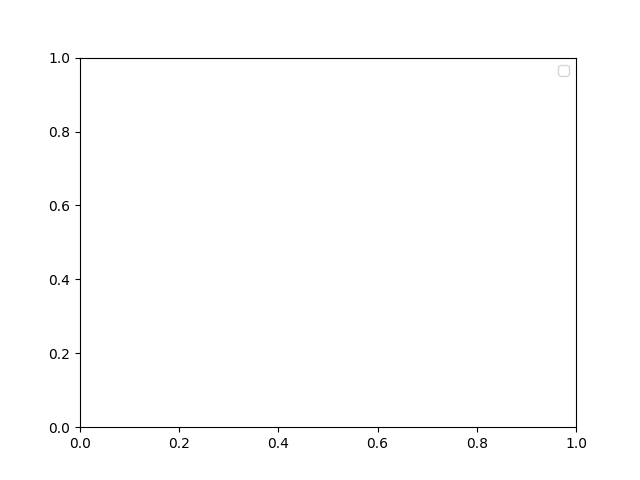

In [10]:
ppg ={}
filtered_ppg ={}
ppg_seg = {}
avg_pulse_ppg = {}
ppg_indices = {}
fs = 100

plt.figure(0)
plt.clf()
for patient,data in dataset.items():
    dataframe = pd.read_csv("Data/"+data[0])
    ppg[patient] = dataframe["SCData"]
    filtered_ppg[patient] = filt(ppg[patient],fs)
    ppg_seg[patient] = filtered_ppg[patient][2][data[1]:data[2]]
    avg_pulse_ppg[patient] = np.mean(get_norm_pulses(ppg_seg[patient], True), axis=0)
    ppg_indices[patient] = pulse_indices(avg_pulse_ppg[patient])
    print(f"ppg_indices['{patient}'] ={ppg_indices[patient]}")
    plt.plot(avg_pulse_ppg[patient])
    
plt.legend(dataset.keys())
plt.show()

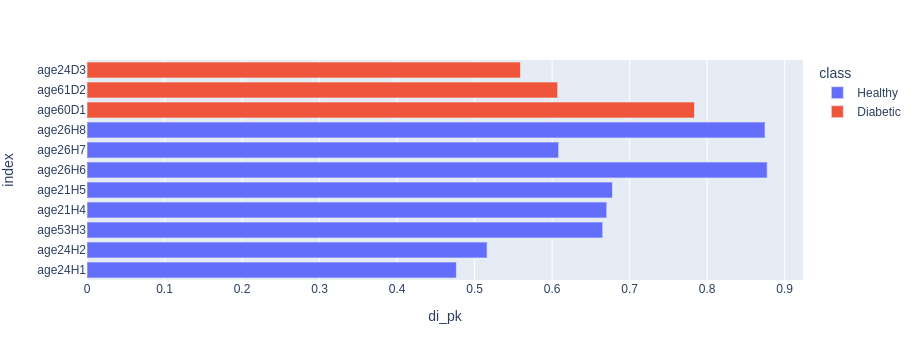

In [14]:
df_ppg = pd.DataFrame.from_dict(ppg_indices, orient='index')
df_ppg.columns =["sys_pk", "AUC", "delt_T", "CT", "RI", "SI", "STT", "IPA", "pulse_wa_ratio" , "der_pk", "peak_diff_t", "di_pk"]
df_ppg["class"] = [x[3] for x in dataset.values()]
df_ppg.plot.bar("di_pk", color="class")

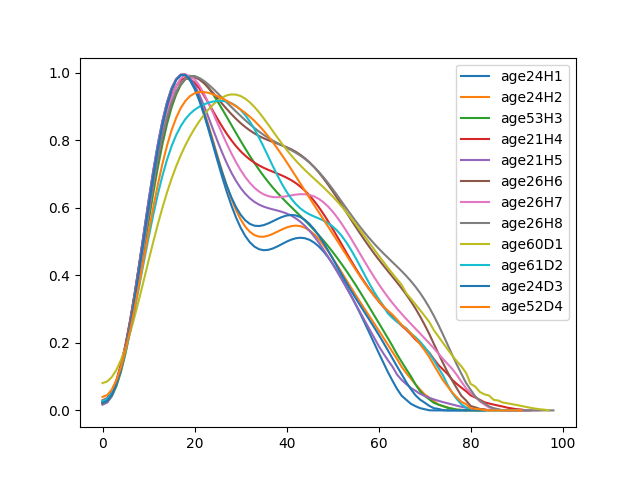

In [8]:
pat ={}
filtered_pat ={}
pat_seg = {}
avg_pulse_pat = {}
pat_indices = {}
fs = 100

plt.figure(1)
for patient,data in dataset.items():
    dataframe = pd.read_csv("Data/"+data[0])
    pat[patient] = dataframe["PCData"]
    filtered_pat[patient] = filt(pat[patient],fs)
#     filtered_pat[patient] = filt_with_params(pat[patient],fs, 80, 6, 201, 0.5)
    pat_seg[patient] = filtered_pat[patient][2][data[1]:data[2]]
#     avg_pulse_pat[patient] = np.mean(get_pulses(pat_seg[patient]), axis=0)
    avg_pulse_pat[patient] = np.mean(get_norm_pulses(pat_seg[patient], True), axis=0)
    pat_indices[patient] = pulse_indices(avg_pulse_pat[patient])
#     print(f"pat_indices['{patient}'] ={pat_indices[patient]}")
    plt.plot(avg_pulse_pat[patient])
    
plt.legend(dataset.keys())
plt.show()

In [128]:
df_pressure = pd.DataFrame.from_dict(pat_indices, orient='index')
df_pressure.columns =["sys_pk", "AUC", "delt_T", "CT", "RI", "SI", "STT", "IPA", "pulse_wa_ratio"]
df_pressure["class"] = [x[3] for x in dataset.values()]
df_pressure.plot.bar("CT", color="class")

ValueError: Length of values (8) does not match length of index (12)

In [ ]:
df_pressure = pd.DataFrame.from_dict(pat_indices, orient='index')
df_pressure.columns =["sys_pk", "AUC", "delt_T", "CT", "RI", "SI", "STT", "IPA", "pulse_wa_ratio"]
df_pressure["class"] = ["Healthy", "Healthy","Healthy","Healthy","Healthy", "Diabetic", "Diabetic"]
df_pressure.plot.bar("CT", color="class")

In [5]:
def filter_temp(raw_data,FILTER_LEN=200):
    b = np.ones(FILTER_LEN)/FILTER_LEN
    mean_data = np.mean(raw_data)
    mean_removed = raw_data - mean_data
    filtered = signal.convolve(mean_removed,b,mode='same',method='auto')
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
#     ax1.plot(mean_removed)
#     ax1.set_title('Raw Signal')
#     ax2.plot(filtered)
#     ax2.set_title('Filtered Signal')
#     plotLines =[ax2.axvline(x) for k,x in temp_events.items()]
    return filtered

def stable_gradient(x,t):
    n = len(x)
    grad = (np.sum(x*t)/n-np.sum(x)*np.sum(t)/n**2)/(np.sum(t*t)/n**2-(np.sum(t)/n)**2)
    return grad

def temp_indices(temp_diff, fs, cuff_release):
    time = np.arange(len(temp_diff))/fs # get this from timestamps
#     cuff_release = 4900 #np.argmin(temp_diff)
    fall_range = range(cuff_release - (100*fs),cuff_release)
    temp_fall = stable_gradient(temp_diff[fall_range],time[fall_range])
    rise_range = range(cuff_release,min(cuff_release+int(120*fs), len(temp_diff)))
    temp_rise = stable_gradient(temp_diff[rise_range],time[rise_range])
    return [temp_fall,temp_rise, temp_rise/temp_fall]

In [3]:
def detrend(data):
    # data should be larger than 20,000 and have shape (20000,)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.linspace(1000,2500,1500),data[1000:2500])
    l = len(data)
    a2 =0
    x = np.linspace(0,l,l)
    leakage = x*a2 + x*slope + intercept
    return data-leakage


temp_indices['age24H1'] =[0.0026797965125399366, -0.002714612037930856, -1.0129918541307157]
temp_indices['age24H2'] =[0.0031448169143398147, -0.003317684884238767, -1.0549691681924962]
temp_indices['age21H4'] =[0.0027511952561856744, -0.0017802896372634868, -0.647096796659836]
temp_indices['age21H5'] =[0.0016577666428099684, -0.0008839641147652836, -0.5332259028127962]
temp_indices['age26H7'] =[0.0006498973005584652, -0.0017407696843080773, -2.6785304121315954]
temp_indices['age60D1'] =[-0.00023088554670658057, -0.004304453794979451, 18.643236254410237]
temp_indices['age61D2'] =[0.00042966358857926247, -7.268785748945285e-05, -0.1691738825945306]
temp_indices['age52D4'] =[0.004724596421215787, -0.0037548253940082542, -0.7947399225777722]


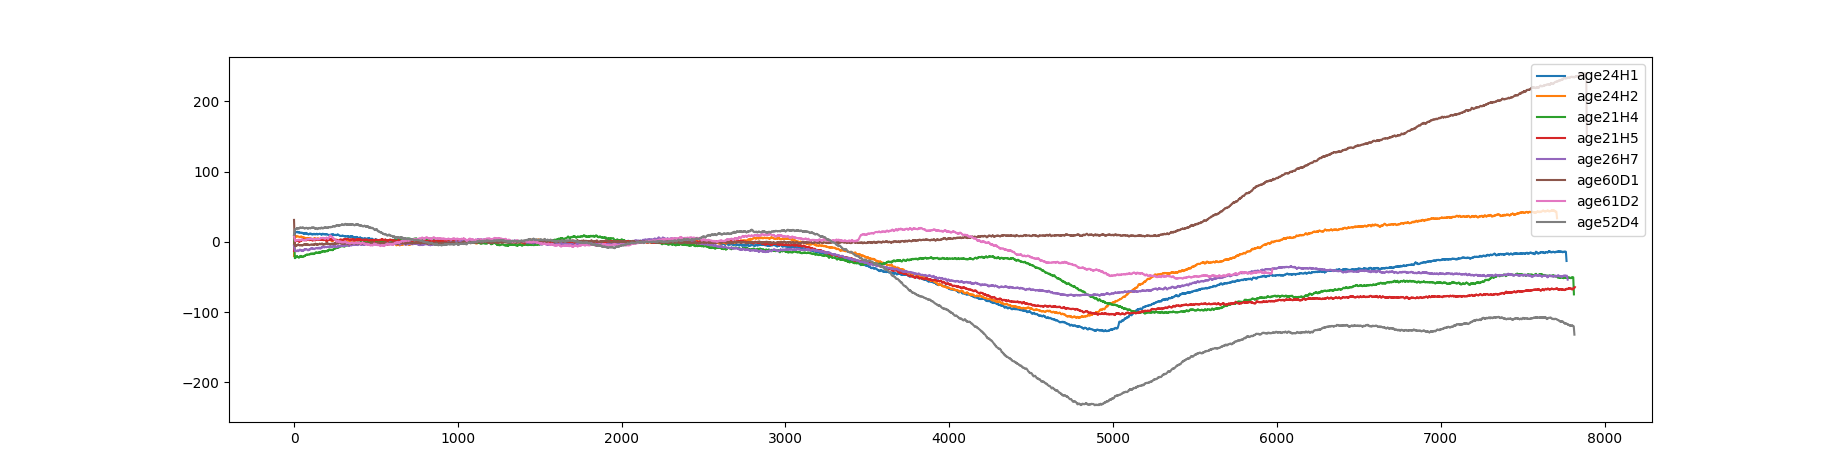

In [24]:
temp ={}
filtered_temp ={}
temp_seg = {}
temp_indx = {}
fs = 10

plt.figure(3)
plt.clf()
for patient,data in dataset.items():
    
    dataframe = pd.read_csv("Data/"+data[0])
    r_dominant = data[5]
    mul = 1
    if(not r_dominant):
        mul = -1
    temp[patient] = mul*(dataframe["TData"] - dataframe["TCData"]).dropna()
    filtered_temp[patient] = filter_temp(temp[patient],fs)
    plt.plot(detrend(filtered_temp[patient]))
    temp_indx[patient] = temp_indices(filtered_temp[patient], fs, data[4] )
    print(f"temp_indices['{patient}'] ={temp_indx[patient]}")
    
plt.legend(dataset.keys())
plt.show()

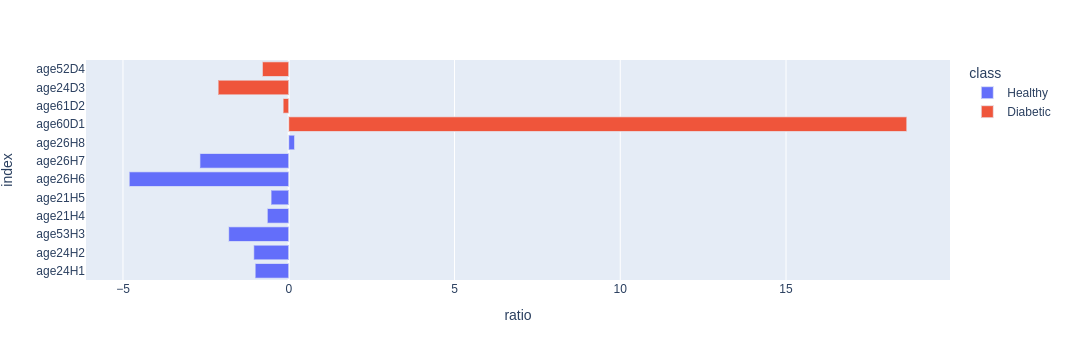

In [143]:
df_temp = pd.DataFrame.from_dict(temp_indx, orient='index')
df_temp.columns =["rise_grad", "fall_grad", "ratio"]
df_temp["class"] = [x[3] for x in dataset.values()]
df_temp.plot.bar("ratio", color="class")

In [19]:
pulses_D3 = get_pulses(filtered_D3[2][14400:17000])
avg_pulse_D3 = np.mean(pulses_D3, axis=0)
indices_D3 = pulse_indices(avg_pulse_D3)
print(indices_D3)

[189.83825677691178, 11190.409791919667, 56, 15, 0.9788437101506953, 2.9464285714285716, 0.07901463200658881, 2.457452949159445, 0.5794406347149846]


In [20]:
pulses_H1 = get_pulses(seg_H1)
avg_pulse_H1 = np.mean(pulses_H1, axis=0)
indices_H1 = pulse_indices(avg_pulse_H1)
pulses_H2 = get_pulses(seg_H2)
avg_pulse_H2 = np.mean(pulses_H2, axis=0)
indices_H2 = pulse_indices(avg_pulse_H2)
pulses_H3 = get_pulses(seg_H3)
avg_pulse_H3 = np.mean(pulses_H3, axis=0)
indices_H3 = pulse_indices(avg_pulse_H3)
pulses_H4 = get_pulses(seg_H4)
avg_pulse_H4 = np.mean(pulses_H4, axis=0)
indices_H4 = pulse_indices(avg_pulse_H4)
pulses_H5 = get_pulses(seg_H5)
avg_pulse_H5 = np.mean(pulses_H5, axis=0)
indices_H5 = pulse_indices(avg_pulse_H5)

pulses_D1 = get_pulses(seg_D1)
avg_pulse_D1 = np.mean(pulses_D1, axis=0)
indices_D1 = pulse_indices(avg_pulse_D1)
pulses_D2 = get_pulses(seg_D2)
avg_pulse_D2 = np.mean(pulses_D2, axis=0)
indices_D2 = pulse_indices(avg_pulse_D2)


In [22]:
print("Healthy 1", indices_H1)
# print("Healthy 2")
print(indices_H2)
# print("Healthy 3")
print(indices_H3)
# print("Healthy 4")
print(indices_H4)
# print("Healthy 5")
print(indices_H5)
# print("Diabetes 1")
print(indices_D1)
# print("Diabetes 2")
print(indices_D2)

[199.67207980082327, 6488.8333625338, 26, 17, 0.5148753603048166, 6.346153846153846, 0.08513959496469324, 1.0493107290764536, 0.40065691748090937]
[240.7217751139734, 8298.410436524873, 24, 18, 0.5488621845661878, 6.875, 0.07477512157542718, 0.9320090280223354, 0.35310474077285053]
[217.13389094965515, 8199.275295558677, 18, 20, 0.6489006725034314, 9.166666666666666, 0.09210906649592171, 0.8399710592547275, 0.3868580792828712]
[172.43817076518548, 7277.594817291029, 18, 18, 0.7242284813363913, 9.166666666666666, 0.10438524092505697, 1.3733804336865922, 0.539323744779461]
[243.42910252375887, 8570.303732581957, 18, 18, 0.599581329622217, 9.166666666666666, 0.0739435006471471, 0.9801831579968572, 0.3491776419448613]
[58.8863793009275, 2789.923134552762, 29, 29, 0.5139791208528345, 5.689655172413793, 0.4924738172778646, 0.3569917672054986, 1.6642218652838183]
[218.00401453795746, 9533.224180603953, 26, 26, 0.560827444333531, 6.346153846153846, 0.11926385876473411, 0.37855409554965747, 0.4

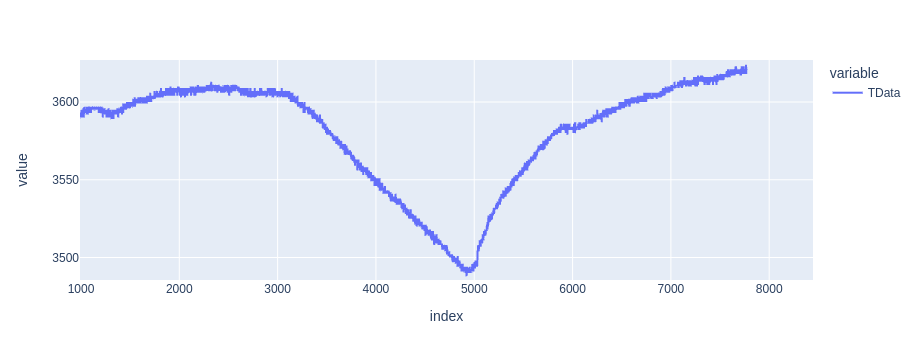

In [47]:
dataframe = pd.read_csv("Data/age24Jan52022.csv")
dataframe["TData"].plot()

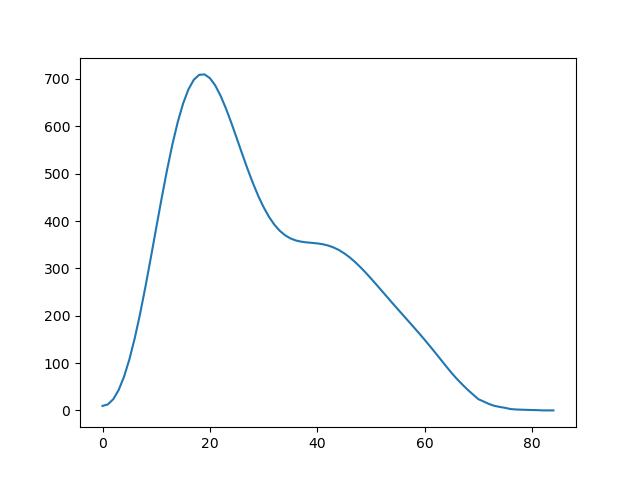

In [98]:
%matplotlib widget
plt.plot(avg_pulse_H2)
plt.show()

In [ ]:
%matplotlib widget
plt.plot(avg_pulse_H1)
plt.show()

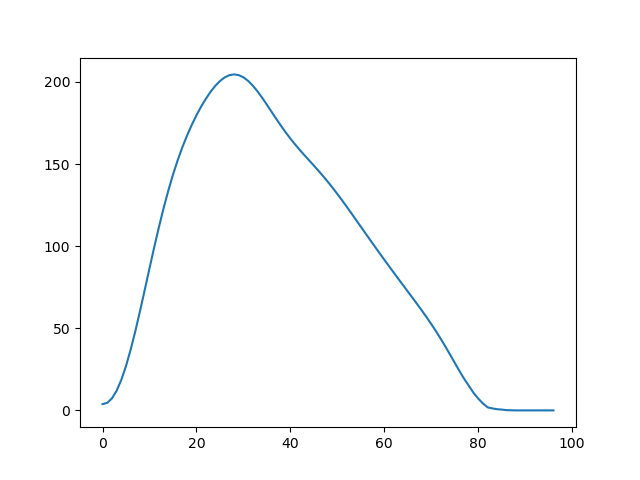

In [99]:
%matplotlib widget
plt.plot(avg_pulse_D1)
plt.show()

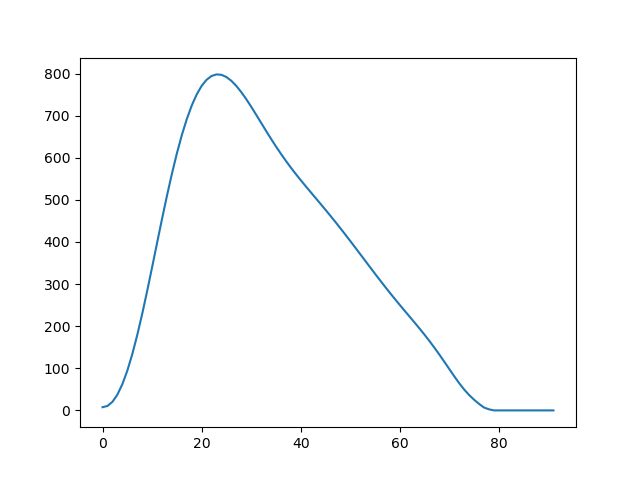

In [100]:
%matplotlib widget
plt.plot(avg_pulse_D2)
plt.show()

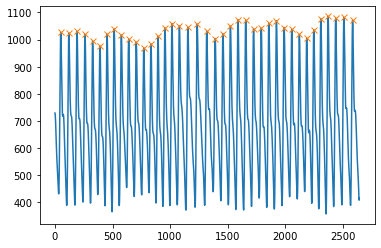

In [16]:
from scipy.signal import find_peaks

peaks_H, _ = find_peaks(H_seg, distance=60)
plt.plot(H_seg)
plt.plot(peaks_H, H_seg[peaks_H], "x")
plt.show()
# print(H_seg)

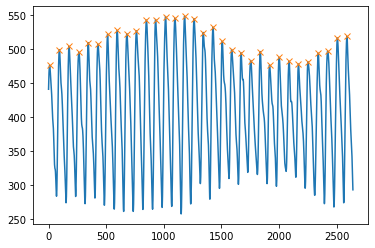

In [17]:
peaks_D, _ = find_peaks(D_seg, distance=60)
plt.plot(D_seg)
plt.plot(peaks_D, D_seg[peaks_D], "x")
plt.show()